In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
### Seed
seed = 100

In [86]:
### Reading .pkl file
num_chr = '22'
pd_df = pd.read_pickle(f"/mnt/wd/nsap/imp3/chr{num_chr}.pkl")
print('Original DF: ', pd_df, sep='\n')

## Saving classes
classes = pd_df['PHENOTYPE']
# encodes [1 2] as [0 1]
le = LabelEncoder()
classes = le.fit_transform(classes)
classes = pd.Series(classes)

## Saving 1st two columns
pd_df_out = pd_df[['IID','PHENOTYPE']].copy()
pd_df.drop(['IID','PHENOTYPE'], axis=1, inplace=True)

# ### One-Hot encode
# print('Performing one-hot encoding...')
# enc = OneHotEncoder(sparse=False, handle_unknown='error')
# enc.fit(pd_df)
# pd_df = enc.transform(pd_df)
# pd_df_columns = enc.get_feature_names_out()
# pd_df = pd.DataFrame(pd_df, columns=pd_df_columns)
# print('Encoded...')
# print(pd_df.head)
pd_df = pd_df.astype("category")


Original DF: 
             IID  PHENOTYPE  rs5747010_A  rs5746647_C  rs16980739_A  \
0      100000411          2            0            0             0   
1      200000078          2            1            0             0   
2      200000431          2            1            0             0   
3      200000522          2            0            0             0   
4      200000732          2            0            0             0   
...          ...        ...          ...          ...           ...   
1322  2905137261          2            1            0             0   
1323  2905650319          2            2            0             0   
1324  2905798401          2            1            0             0   
1325  2906388224          2            0            0             0   
1326  2908392985          2            0            0             0   

      rs5747968_C  rs5747999_C  rs5746679_A  rs11089263_C  rs2096537_A  ...  \
0               0            0            0           

In [88]:
### Split training set from general_set
print('Splitting dataset...')
training_set, test_set, training_classes, test_classes = train_test_split(pd_df,
                                                                          classes,
                                                                          test_size=0.2,
                                                                          random_state=seed)
print(f"Original class counts in training: {Counter(training_classes)}")
print(f"Original class counts in test: {Counter(test_classes)}")

Splitting dataset...
Original class counts in training: Counter({1: 762, 0: 299})
Original class counts in test: Counter({1: 190, 0: 76})


In [51]:
### Repeated stratified k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=seed)

In [49]:
### Define model without tuning parameters 
clf = xgb.XGBClassifier(tree_method="hist", 
                        enable_categorical=True, 
                        random_state=seed,
                        n_jobs=5)


In [36]:
### Fit model
clf.fit(training_set, training_classes)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=5, num_parallel_tree=None,
              predictor=None, random_state=100, ...)

In [89]:
cv_scores = cross_validate(clf,
                           training_set,
                           training_classes, 
                           cv=cv,
                           return_estimator=True,
                           scoring=('accuracy',
                                    'precision_macro',
                                    'recall_macro',
                                    'f1_macro'),
                           n_jobs=10)

In [72]:
print(cv_scores)

{'fit_time': array([76.38137817, 95.71520472, 90.40442586, 81.79306316, 89.91044784]), 'score_time': array([20.19823599, 15.4293201 , 15.10589504, 14.03345418, 14.0401845 ]), 'estimator': [XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=5, num_parallel_tree=None,
              predictor=None, random_state=100, ...), XGBClassifier(base_score=None, booster=None, callbacks=None,
  

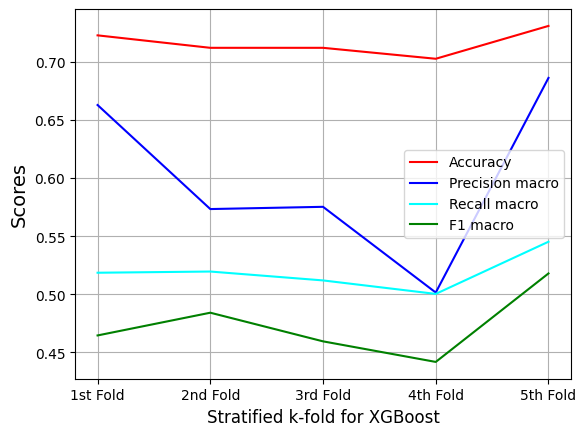

In [73]:
# Plot cv
labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
X_axis = np.arange(len(labels))
ax = plt.gca()
plt.plot(cv_scores['test_accuracy'], color='red', label='Accuracy')
plt.plot(cv_scores['test_precision_macro'], color='blue', label='Precision macro')
plt.plot(cv_scores['test_recall_macro'], color='cyan', label='Recall macro')
plt.plot(cv_scores['test_f1_macro'], color='green', label='F1 macro')

plt.xticks(X_axis, labels)
plt.xlabel(f"Stratified k-fold for XGBoost", fontsize=12)
plt.ylabel('Scores', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# predicting
pred_classes = cv_scores['estimator'][4].predict(test_set)
print(f"Original test_classes: {Counter(test_classes)}")
print(f"Predicted pred_classes: {Counter(pred_classes)}")


Original test_classes: Counter({1: 190, 0: 76})
Predicted pred_classes: Counter({1: 253, 0: 13})


In [79]:
# predict for the fold from cv
inx_dict = {}
for i, (train_index, test_index) in enumerate(cv.split(training_set, training_classes)):
    inx_dict[i] = {'train':[train_index],
                   'test':[test_index]}
#     print(f"Fold {i+1}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

# create subsets of data and classes using the fold indeces
# from train/test splitted dataset
best_train_classes = training_classes.iloc[inx_dict[2]['train'][0]]
best_train_set = training_set.iloc[inx_dict[2]['train'][0]]
best_test_classes = training_classes.iloc[inx_dict[2]['test'][0]] 
best_test_set = training_set.iloc[inx_dict[2]['test'][0]]
print(f"Original class counts: {Counter(best_train_classes)}")

# predicting
pred_classes = cv_scores['estimator'][4].predict(test_set)
print(f"Original test_classes: {Counter(test_classes)}")
print(f"Predicted pred_classes: {Counter(pred_classes)}")
# evaluating prediction
precision = precision_score(best_test_classes, 
                            test_pred_classes, 
                            average=None)
print(precision)
recall = recall_score(best_test_classes, 
                      test_pred_classes, 
                      average=None)
print(recall)
f1_score_ = f1_score(best_test_classes, 
                                    test_pred_classes, 
                                    average=None)
print(f1_score_)

Fold 1:
  Train: index=[   0    1    2    3    4    6    8    9   10   11   13   14   15   16
   18   20   21   22   24   25   26   27   28   29   31   32   33   34
   35   36   38   39   40   41   42   43   44   46   47   48   50   51
   52   53   54   56   59   63   64   65   66   67   68   70   71   72
   73   74   75   76   77   78   79   80   81   82   84   85   87   88
   89   90   91   92   93   94   95   96   97   98   99  100  102  103
  104  105  106  107  108  109  110  111  112  113  114  115  116  118
  119  120  121  122  123  124  125  126  127  128  130  131  132  133
  134  135  136  137  139  140  141  142  143  144  147  149  150  151
  152  154  157  158  159  160  161  162  163  165  166  167  168  169
  170  175  176  177  179  182  183  184  185  187  189  190  191  192
  193  195  198  199  200  201  202  205  207  208  209  210  211  212
  214  215  216  217  218  219  221  222  223  224  225  226  227  228
  229  231  232  233  234  235  237  238  239  240  24

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [40]:
# Get feature importances
feat_imp = clf.feature_importances_
print(feat_imp)

[0. 0. 0. ... 0. 0. 0.]


In [46]:
# make predictions
pred_classes = clf.predict(test_set)
print(f"Original test_classes: {Counter(test_classes)}")
print(f"Predicted pred_classes: {Counter(pred_classes)}")

# f1-score
f1_score_ = f1_score(test_classes, pred_classes, average=None)
print(f1_score_)

Original test_classes: Counter({1: 190, 0: 76})
Predicted pred_classes: Counter({1: 252, 0: 14})
[0.11111111 0.81900452]


In [ ]:
# Defining the parameters grid
parameters_grid = {'max_depth': [4, 5, 6], 
                   'learning_rate': [0.1, 0.2, 0.3],
                   'n_estimators': [50, 100, 150], 
                   'gamma': [0, 20], 
                   'subsample': [0.8, 1], 
                   'colsample_bytree': [0.8, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}